In [31]:
#import libraries

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.patches import Arc, Circle, Rectangle
import itertools

from PIL import Image
import time


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools

from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

import xgboost as xgb

import seaborn as sns

import pickle


In [32]:
# reading in csv file

df = pd.read_csv('csv_files/Final_df.csv', index_col = 0)

In [33]:
# removing the 3 multiposition players as they do not fit into the dataset

df = df[(df['Pos'] != 'PF-SF') & (df['Pos'] != 'SG-PG') & (df['Pos'] != 'SF-SG')]

In [34]:
# taking a look at the value counts

df.Pos.value_counts()

SG    407
PG    365
PF    353
C     352
SF    347
Name: Pos, dtype: int64

### Making the targer for 3 class models

In [35]:
# creating an empty list to store the new 3 class position target

new_positions = []

# replacing power forwards and centers to Bigs
# replacing small forwards and shooting guards to wings

for x in df.Pos:
    if (x == 'PF') or (x == 'C'):
        new_positions.append('Big')
    elif (x == 'SG') or (x == 'SF'):
        new_positions.append('Wing')
    else:
        new_positions.append(x)
        
# this has become very common in the new nba, pg, wing and big. Its because the nba has become more positionless
# so having players in the middle section is very important but moreso its because those positions are very similar
# to eachother. Sg and sf both operate without the ball more, but do a little of everything and generally need to 
# shoot a lot whereas bigs have more responsibility need the basket

In [36]:
# creating a new position column for the 3 positions

df['new_pos'] = new_positions

In [37]:
# creating the features and the target variables for 5 class

X = df.drop(columns = ['Player', 'PLAYER_ID', 'Pos', 'new_pos'])
y = df.Pos

In [38]:
# creating the features and the target variable for 3 class

X3 = df.drop(columns = ['Player', 'PLAYER_ID', 'Pos', 'new_pos'])
y3 = df.new_pos

# EDA

I am doing some eda to get an idea of what i have in my data and what patterns i might find. Also see if i can find data that may in fact be irrelevant

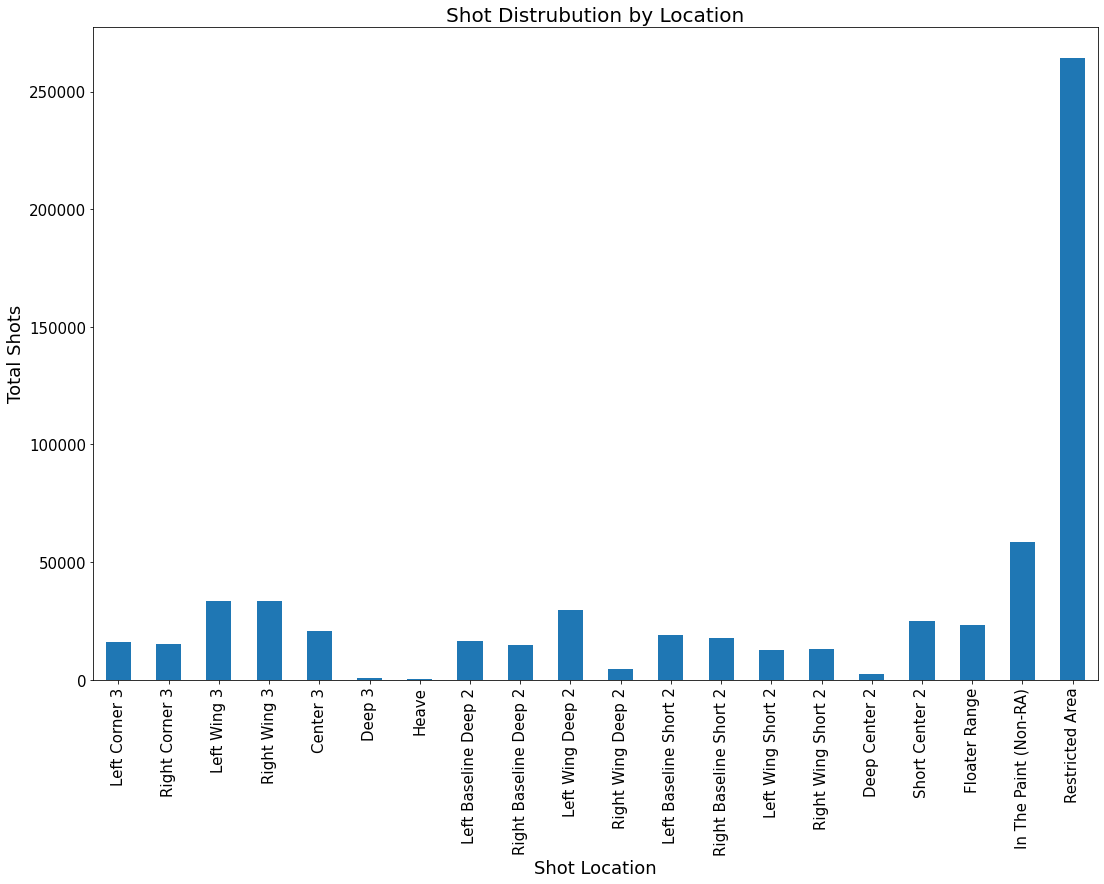

In [9]:
# graph showing the breakdown of the different shot locations

ax = X.sum()[:20].plot.bar(figsize = (18,12))

ax.set_title('Shot Distrubution by Location', fontdict = {'fontsize' : 20})
ax.set_ylabel('Total Shots', fontdict = {'fontsize' : 18})
ax.set_xlabel('Shot Location', fontdict = {'fontsize' : 18})
ax.set_xticklabels(['Left Corner 3', 'Right Corner 3', 'Left Wing 3', 'Right Wing 3', 'Center 3',
'Deep 3', 'Heave', 'Left Baseline Deep 2', 'Right Baseline Deep 2', 'Left Wing Deep 2', 
'Right Wing Deep 2', 'Left Baseline Short 2', 'Right Baseline Short 2', 'Left Wing Short 2',
'Right Wing Short 2', 'Deep Center 2', 'Short Center 2', 'Floater Range', 
'In The Paint (Non-RA)', 'Restricted Area'], fontdict = {'fontsize' : 15})
ax.set_yticklabels([0, 50000, 100000, 150000, 200000, 250000], fontdict = {'fontsize' : 15})

plt.savefig('Images/shooting_by_position.png')

# wanted to get an idea of how the shots are broken down to see any patterns. The important thing to see from this
# is that restricted area shots are most common by a lot, which means all the classes have a restricted area shots so
# so its likely to not have a major affect on the final data

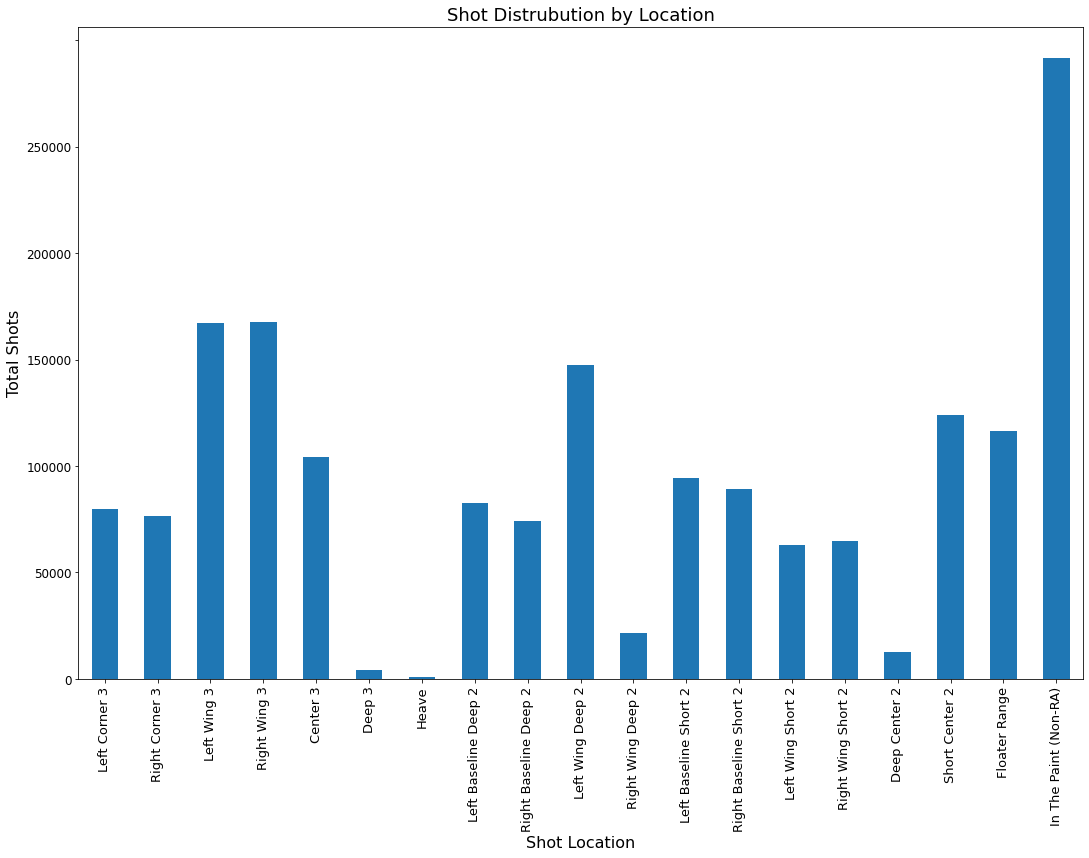

In [10]:
# Same breakdown but not including restricted area which is the large magority of shots

ax2 = X.sum()[:19].plot.bar(figsize = (18,12))

ax2.set_title('Shot Distrubution by Location', fontdict = {'fontsize' : 18})
ax2.set_ylabel('Total Shots', fontdict = {'fontsize' : 16})
ax2.set_xlabel('Shot Location', fontdict = {'fontsize' : 16})
ax2.set_xticklabels(['Left Corner 3', 'Right Corner 3', 'Left Wing 3', 'Right Wing 3', 'Center 3',
'Deep 3', 'Heave', 'Left Baseline Deep 2', 'Right Baseline Deep 2', 'Left Wing Deep 2', 
'Right Wing Deep 2', 'Left Baseline Short 2', 'Right Baseline Short 2', 'Left Wing Short 2',
'Right Wing Short 2', 'Deep Center 2', 'Short Center 2', 'Floater Range', 
'In The Paint (Non-RA)'], fontdict = {'fontsize' : 13})
ax2.set_yticklabels([0, 50000, 100000, 150000, 200000, 250000], fontdict = {'fontsize' : 12})

plt.savefig('Images/shooting_by_location_wo_restricted.png')

# just wanted to see a closer breakdown of the other locations

new_pos
Big     AxesSubplot(0.125,0.125;0.775x0.755)
PG      AxesSubplot(0.125,0.125;0.775x0.755)
Wing    AxesSubplot(0.125,0.125;0.775x0.755)
Name: PTS, dtype: object

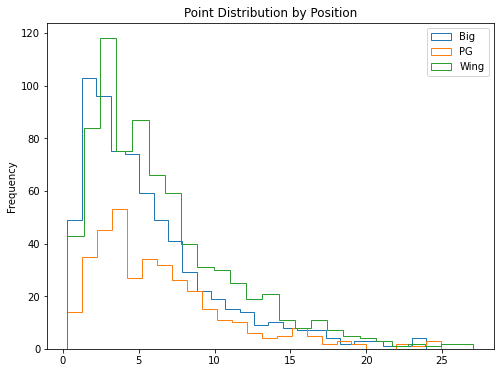

In [14]:
# Looking at points for each position

df.groupby('new_pos')['PTS'].plot(kind='hist', histtype='step', bins= 25, figsize=(8,6), legend = True, 
                                   title = 'Point Distribution by Position')


# thing to note is that it is actually not that big of a difference even if the shots look different. Thats because
# pg has half as many players as the other 2 so even if the frequency is lower its only because of quantity. So this
# means that points dont have a major influence on the data

new_pos
Big     AxesSubplot(0.125,0.125;0.775x0.755)
PG      AxesSubplot(0.125,0.125;0.775x0.755)
Wing    AxesSubplot(0.125,0.125;0.775x0.755)
Name: AST, dtype: object

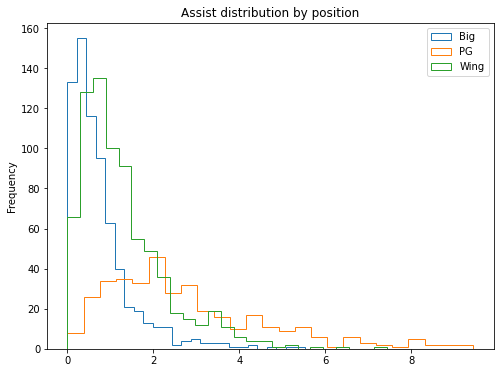

In [15]:
# looking at assists however we see a big difference

df.groupby('new_pos')['AST'].plot(kind='hist', histtype='step', bins= 25, figsize=(8,6), legend = True, title = 'Assist distribution by position')


# here we can see that pgs get much more assists on average than bigs or wings, with a majority of pgs 
# having at least 2 a game whereas centers and wings fall below 2 a game

### Plotting points on a court

In [3]:
# getting the original x, y coordinates for the shots

shot_chart = pd.read_csv('csv_files/2019-20_nba_shot_charts.csv')

In [4]:
## http://savvastjortjoglou.com/nba-shot-sharts.html

# this function is to draw the court where i will be placing all of the shot charts to give a clear idea of the
# differences/similarities between the positions

from mod_5_functions import draw_court

In [13]:
# getting shot charts for 6 different players, 

# 2 guards, 1 star and 1 solid player
# 2 forwards, 1 star and 1 role player
# 2 bigs, 1 star and 1 less proficient big man

Harden = shot_chart[shot_chart.PLAYER_NAME == 'James Harden']

Tucker = shot_chart[shot_chart.PLAYER_NAME == 'P.J. Tucker'] 

Davis = shot_chart[shot_chart.PLAYER_NAME == 'Anthony Davis']
Deandre = shot_chart[shot_chart.PLAYER_NAME == 'DeAndre Jordan']

lebron = shot_chart[shot_chart.PLAYER_NAME == 'LeBron James']
jokic = shot_chart[shot_chart.PLAYER_NAME == 'Nikola Jokic']


Plotting for 6 different player types explained earlier

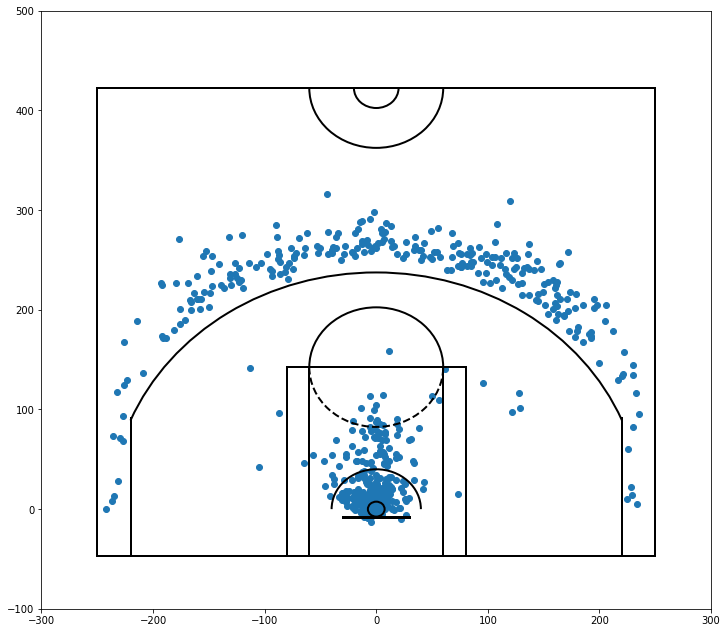

In [6]:
# James Harden Shot Chart

plt.figure(figsize=(12,11))
plt.scatter(Harden.LOC_X, Harden.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

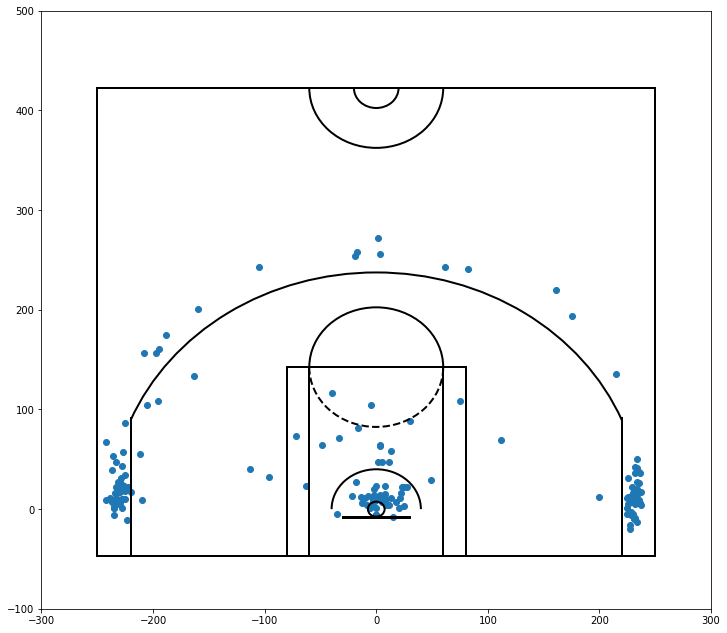

In [9]:
# PJ Tucker Shot Chart

plt.figure(figsize=(12,11))
plt.scatter(Tucker.LOC_X, Tucker.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

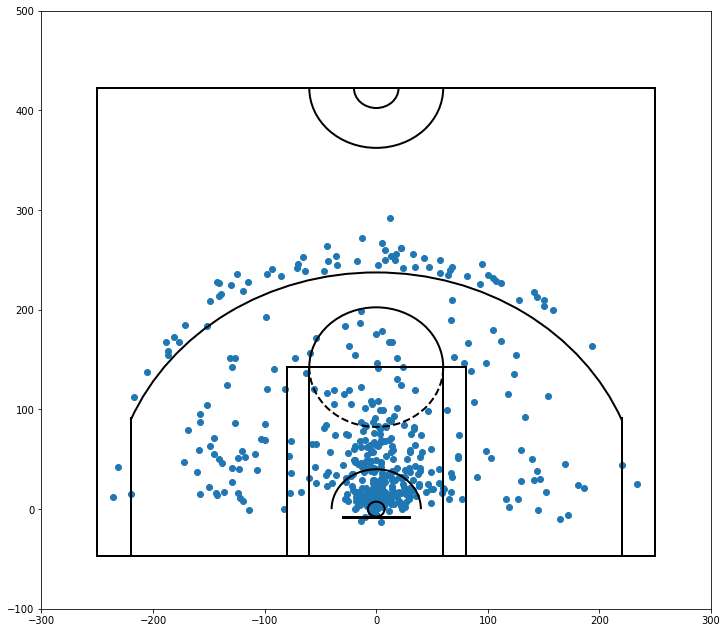

In [17]:
# Anthony Davis Shot Chart

plt.figure(figsize=(12,11))
plt.scatter(jokic.LOC_X, jokic.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

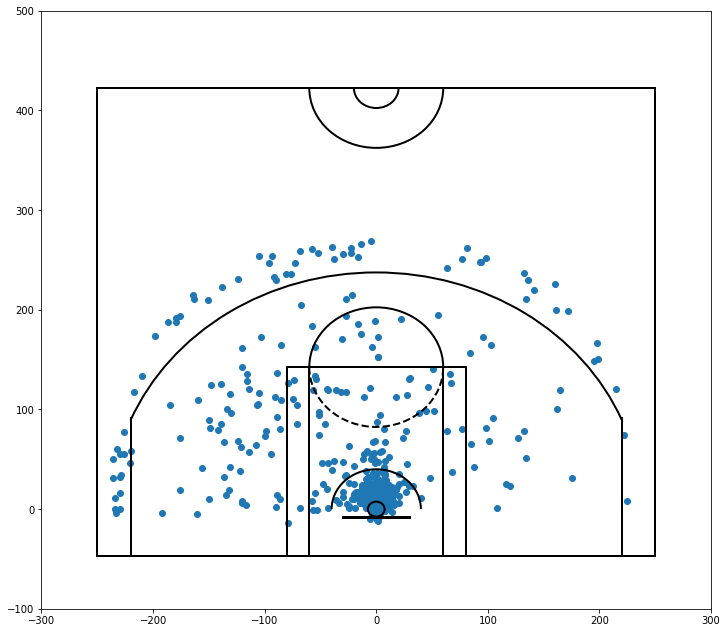

In [10]:
# Anthony Davis Shot Chart
plt.subplot()
plt.figure(figsize=(12,11))
plt.scatter(Davis.LOC_X, Davis.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

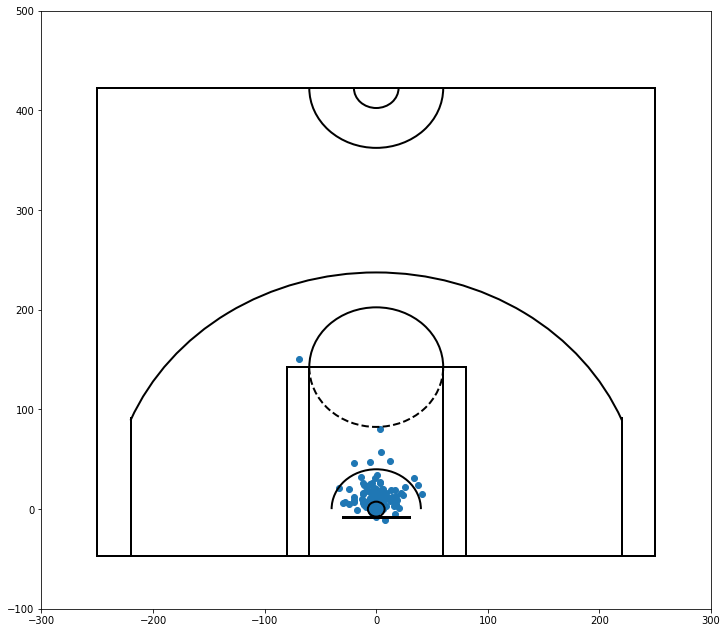

In [11]:
# Deandre Jordan Shot Chart

plt.figure(figsize=(12,11))
plt.scatter(Deandre.LOC_X, Deandre.LOC_Y)
draw_court(outer_lines=True)

plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

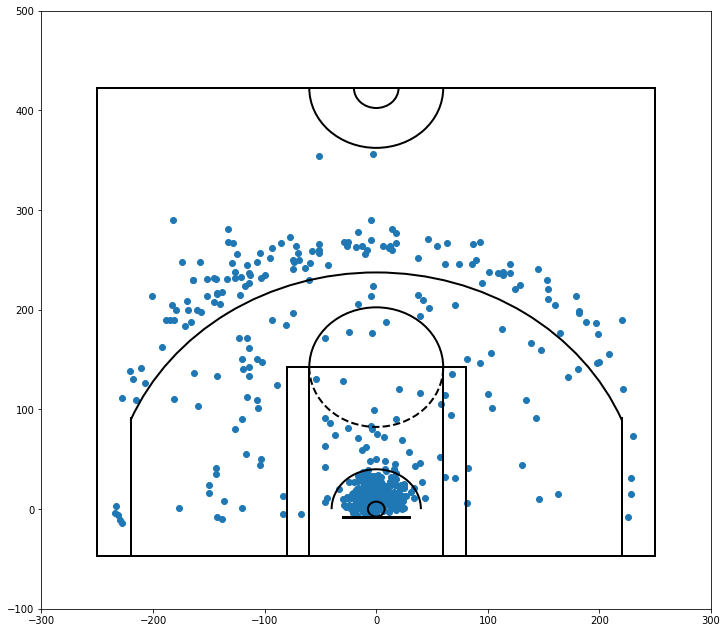

In [14]:
# Dirk Nowitzki Shot Chart

plt.figure(figsize=(12,11))
plt.scatter(lebron.LOC_X, lebron.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

In [ ]:
# Nikola Jokic Shot Chart

plt.figure(figsize=(12,11))
plt.scatter(jokic.LOC_X, jokic.LOC_Y)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

The breakdown of the shots dont show much in terms of what i should do to model the data but the actual shot charts do. 

The 2 different big man positons shot charts actually do look pretty similar with anthony davis and jokic both primarily focused on the inside and stemming out from there. While shooting charts like james harden, a wing player, are different with much more focus on the 3 pointer. Dirk Nowitzki is an anomoly as he has an extremely diverse shot profile that resembles that of a wing player with great shooting from all over the court.

We could also see clear differences in the assists numbers between the pgs and the other positions as they were more spread out while the bigs and wings had a large majority in the 0-3 range. Points didnt show as much because even though it looks a little different between pg and the other 2 pg just has half as many data points so its more about the quantity that makes it look different and not the actual quality of the scoring.

# 5 classes

## Train Test Split

In [10]:
# train test split for 5 class data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24, test_size = .25) 

## Dummy classifier

#### First run the dummy classifier to get an idea of what the number i need to beat should be, only predicts the dominant class which is about 21% as the 5 classes are all fairly balanced

In [11]:
# running a dummy classifier to predict the most frequent class

dummy_clf = DummyClassifier(strategy = 'most_frequent')

In [12]:
# fitting and predicting using the dummy classifier than obtaining the accuracy score

dummy_clf.fit(X_train, y_train)

dummy_pred = dummy_clf.predict(X_test)

accuracy_score(dummy_pred, y_test)

0.19956140350877194

# XGB

## XGBoost Model

In [13]:
# XGBoost classifier for 5 class model with no extra hyper parameters

xgb_clf = xgb.XGBClassifier()

In [14]:
# fitting the xgboost to the training data

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
# Getting predictions on the testing data then finding the accuracy of those predictions

xgb_pred = xgb_clf.predict(X_test)

accuracy_score(y_test, xgb_pred)

0.5855263157894737

## XGB Gridsearch

In [37]:
# Gridsearch for xgboost model using different values of max depth, learning rate, n_estimatores and child weight

param_xgb = {'max_depth' : [4, 6, 8, 10], 'learning_rate' : [.01, .05, .1, .2],
             'n_estimators' : [100, 250, 500], 'min_child_weight' : [1,3,5]}

In [39]:
# running gridsearch and fitting the training data

grid_xgb = GridSearchCV(xgb_clf, param_xgb, n_jobs = -1, cv = 3, verbose = 1)

grid_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  5.7min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                      

In [40]:
# using the best estimator to predict and return an accuracy score for the testing data

grid_xgb_pred = grid_xgb.best_estimator_.predict(X_test)

accuracy_score(y_test, grid_xgb_pred)

0.6096491228070176

# Random Forest

## Random Forest Model

In [16]:
# random forest model with no hyperparametes

rf_clf = RandomForestClassifier()

In [17]:
# fitting the training data then testing on the test data and returning an accuracy score 

rf_clf.fit(X_train, y_train)

rf_pred = rf_clf.predict(X_test)

accuracy_score(y_test, rf_pred)

0.5657894736842105

## Random Forest gridsearch

In [43]:
# parameters for gridsearch including max depth, n estimators, criterion, etc

param_rf = {'max_depth': [3, 6, 9, 12, 15], 'n_estimators' : [100, 200, 300, 400, 500], 
              'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 4, 6], 'criterion': ['gini', 'entropy']}

In [46]:
## running the gridsearch and fitting it on the training data

grid_rf = GridSearchCV(rf_clf, param_rfc, n_jobs = -1, cv = 3, scoring = 'accuracy')

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 9, 12, 15],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy')

In [47]:
# predicting on the testing data and returning an accuracy score

rf_grid_pred = grid_rf.best_estimator_.predict(X_test)

accuracy_score(y_test, rf_grid_pred)

0.5942982456140351

# SVM

## SVC Model - 

#### Need to rerun the model with scaled data

In [19]:
## Support vector machine with no hyperparameters

sv_clf = SVC()

In [20]:
# fitting the model on the training set, predicting on the test set and returning a final accuracy score

sv_clf.fit(X_train, y_train)

svc_pred = sv_clf.predict(X_test)

accuracy_score(y_test, svc_pred)

0.2741228070175439

## SVC Gridsearch

In [50]:
# parameters for support vector classifier, the learning rate C and the gamma i found to be the only real 
# hyperparameter that makes a concrete difference to the data

param_svc = {'C': [.1, 1, 10, 100]}

In [52]:
# Running gridsearch for support vector classifier and fitting on the training data

grid_svc = GridSearchCV(sv_clf, param_svc, refit = True, verbose = 1, n_jobs = -1, cv = 3)

grid_svc.fit(X_train, y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100]}, verbose=1)

In [53]:
# Testing the support vector classifier and outputting the accuracy

svc_grid_pred = grid_svc.best_estimator_.predict(X_test)

accuracy_score(y_test, svc_grid_pred)

0.4100877192982456

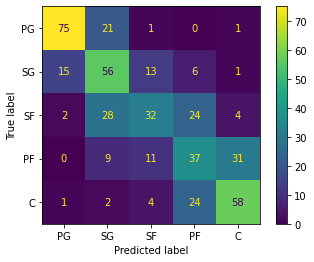

In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

# confusion matrix for 3 class random forest model

plot_confusion_matrix(rf_clf, X_test, y_test, labels = ['PG', 'SG', 'SF', 'PF', 'C'])


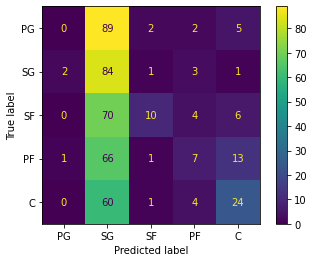

In [21]:
# plotting confusion matric for the support vector classifier

plot_confusion_matrix(sv_clf, X_test, y_test, labels = ['PG', 'SG', 'SF', 'PF', 'C'])

### After taking a look at the confusion matrix i can see that the 2 most mixed up positions are sg and sf and power forward and center. Which makes sense, pg is much different than any other position benefitting from the assist value in the category. But the differences between the 2 wing positions or the 2 bigs do not get the same benefits. 

### So i want to break it down a little bit more and re classify the positions first just using wings for sg and sf


#### ** also note that the svm model, while it does preform well is doing a bad job of actually picking them, mainly just selecting sf which is the middle ground for all the stats

# 3 Classes

## changing from 5 classes to 3 to attempt to clean up the predictions, since the data is coming from 2000-2020 then combining centers and pfs could easily prove to help the data the same way that sg and sf are since the small ball 4 didnt change until around 2015

___

## Train test split

In [39]:
# splitting the training and testing data for the 3 class classifier

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state = 20, test_size = .25) 

In [27]:
# scaling the data for the SVM model

scaler3 = StandardScaler()
scaler3.fit(X3_train)
X3_train_scale = pd.DataFrame(data=scaler3.transform(X3_train), columns = X3.columns)
X3_test_scale = pd.DataFrame(data=scaler3.transform(X3_test), columns = X3.columns)

## Dummy Classifier

In [28]:
#running a dummy classifier, fitting it on the training data, predicting on the testing data and getting the accuracy

dummy_clf2 = DummyClassifier(strategy = 'most_frequent')

dummy_clf2.fit(X3_train, y3_train)

dummy_pred2 = dummy_clf2.predict(X3_test)

accuracy_score(dummy_pred2, y3_test)

0.43859649122807015

## SVM

In [40]:
# running the support vector machine with the same parameters that gave me the best score when gridsearching on the
# 5 class classifier

sv3_clf = SVC(kernel='linear', C = 3, class_weight = None)

In [41]:
# fitting on the training data and predicting on the testing data
# for the 3 class as it was easier to analyze i wanted to also look at the f1, precision 
# and recall along with the accuracy

sv3_clf.fit(X3_train, y3_train)

svc3_pred = sv3_clf.predict(X3_test)

print('Accuracy Score: ' + str(accuracy_score(y3_test, svc3_pred)))

print('F1 Score: ' + str(f1_score(y3_test, svc3_pred, average= None)))

print('Precision Score: ' + str(precision_score(y3_test, svc3_pred, average= None)))

print('Recall Score: ' + str(recall_score(y3_test, svc3_pred, average= None)))

Accuracy Score: 0.8399122807017544
F1 Score: [0.88685015 0.8042328  0.81818182]
Precision Score: [0.87349398 0.80851064 0.82653061]
Recall Score: [0.90062112 0.8        0.81      ]


## RF Model

In [27]:
# random forest model for 3 class classification with the best hyper parameters from the 5 class model gridsearch

rf3_clf = RandomForestClassifier(class_weight = 'balanced', max_depth = 13)

In [28]:
# fitting the data and predicting on the test set

# as with the SVM model, also running results for f1, precision, recall as well as accuracy

rf3_clf.fit(X3_train, y3_train)

rf3_pred = rf3_clf.predict(X3_test)

print('Accuracy Score: ' + str(accuracy_score(y3_test, rf3_pred)))

print('F1 Score: ' + str(f1_score(y3_test, rf3_pred, average= None)))

print('Precision Score: ' + str(precision_score(y3_test, rf3_pred, average= None)))

print('Recall Score: ' + str(recall_score(y3_test, rf3_pred, average= None)))

Accuracy Score: 0.8004385964912281
F1 Score: [0.85       0.75       0.78365385]
Precision Score: [0.85       0.81481481 0.75813953]
Recall Score: [0.85       0.69473684 0.81094527]


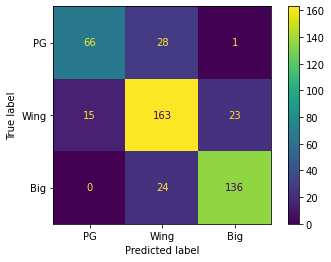

In [29]:
# confusion matrix for 3 class random forest model

plot_confusion_matrix(rf3_clf, X3_test, y3_test, labels = ['PG', 'Wing', 'Big'])

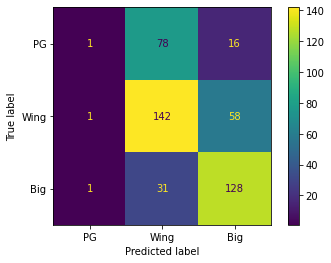

In [30]:
# confusion matrix for 3 class support vector model

plot_confusion_matrix(sv3_clf, X3_test, y3_test, labels = ['PG', 'Wing', 'Big'])

### Again the scores got much better with the svm model correctly predicting over 80% of the scores and the random forest doing very well in the 76% range. this is the best breakdown of the positions that gives the most clear seperations using box score stats. 

### With this model stats such as assists and above the break 3s have a high influence on the pg category, corner 3s, above the break 3s and mid range shots in general have a high influence on the wings and blocks, rebounds, and paint scoring in general are big influencers for the bigs. so there are clear lines drawn here that can help seperate these 3 classes

#### The svm model again had the highest score but a very lackluster confusion matrix

### Finding Feature importance in svm model

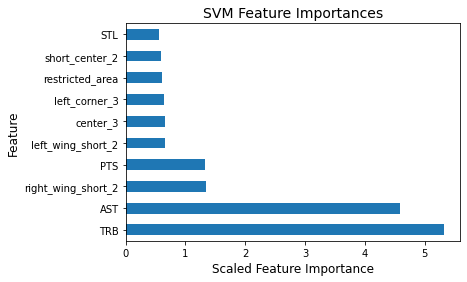

In [13]:
# code to find the feature importance for the 3 class support vector machine and saving the plot 

ax5 = pd.Series(abs(sv3_clf.coef_[0]), index=X3.columns).nlargest(10).plot(kind='barh')


ax5.set_title('SVM Feature Importances', fontdict = {'fontsize' : 14})
ax5.set_ylabel('Feature', fontdict = {'fontsize' : 12})
ax5.set_xlabel('Scaled Feature Importance', fontdict = {'fontsize' : 12})

plt.savefig('Images/Feature_importances')

# RESULTS

After running all the different models i found that just using shot locations for all the players does not do nearly as good of a job as adding in the box score models but some of the shot locations did affect the data and had a large influence on the data. 

- short right baseline (common shot location for bigs)
- left wing 3 & right wing 3 (common shot for most guards and wings)

- in the pain and restricted area also in the top 5 which are very much big men stats

but overall the features that had the biggest impact were still some of the basic box score stats like blocks, rebounds and assists. Blocks and rebounds being a big man dominant feature and assists being big for guards.

The biggest problem comes with the pgs who without the assist category have shot charts that very closely resemble that of a lot of wing players. So while it did still do an ok job at about 56% not having those basic box score stats hurts this version of the model a little too much

#### Pickling the best model

In [42]:
import pickle

In [43]:
with open('SVM_model', 'wb') as handle:
    pickle.dump(sv3_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)